:Here I am training mobile net
# Suhail Bashir - 19COB502

In [1]:
from google.colab import files
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers.core import Dense,Flatten
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import shutil
import os

In [2]:
#mounting drive to retreive dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#copying dataset to main memory of colab, this speeds up training process
%cp -r "/content/drive/MyDrive/BTech_Project/Dataset_2" /content  

In [4]:
#setting sizes for images
img_width = 96
img_height = 96

batch_size = 64

In [5]:
#path for training and testing directory
train_dir = "/content/Dataset_2/train"
test_dir = "/content/Dataset_2/test"

In [6]:
#setting training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15544 files belonging to 4 classes.
Using 12436 files for training.


In [7]:
#setting validation datase
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15544 files belonging to 4 classes.
Using 3108 files for validation.


In [8]:
#setting testing datase
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
)

Found 1952 files belonging to 4 classes.


In [9]:
class_names = train_ds.class_names
print(f"The classes that we have are {class_names}")

The classes that we have are ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [10]:
#checking the dimensions of each batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 96, 96, 3)
(64,)


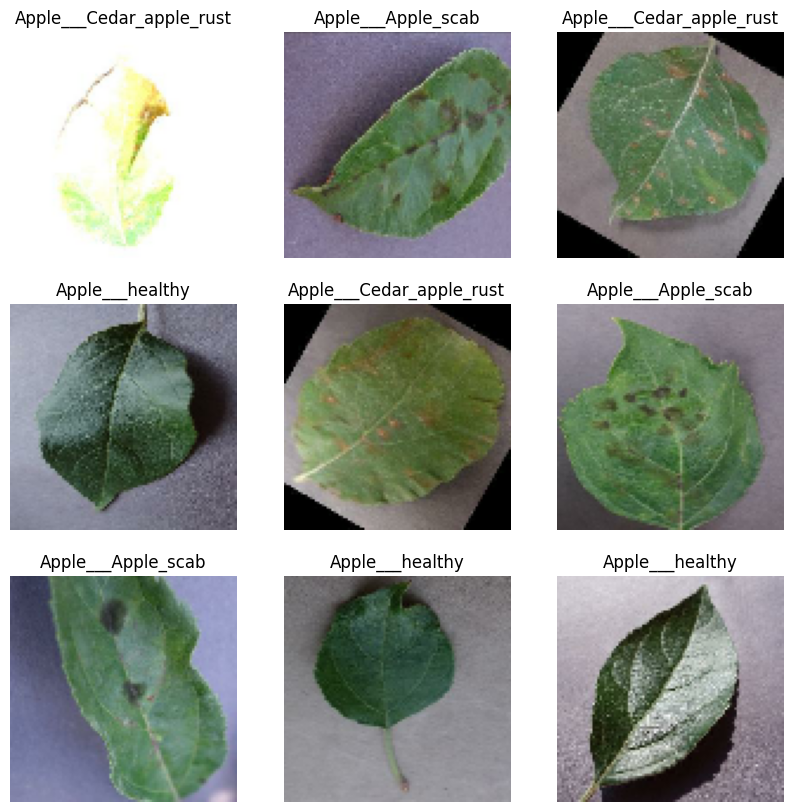

In [11]:
#plotting images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
#getting information regarding number of images in each class in each directory
import os
import pandas as pd

classes = 4

#make a count of the different classes
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/' + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir,'test')
print(train_count)
print(test_count)

       Apple___Cedar_apple_rust  Apple___Black_rot  Apple___healthy  \
train                      3520               3976             4016   

       Apple___Apple_scab  
train                4032  
      Apple___Cedar_apple_rust  Apple___Black_rot  Apple___healthy  \
test                       440                496              502   

      Apple___Apple_scab  
test                 514  


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
from tensorflow.keras.applications import mobilenet_v2
import tensorflow.keras.layers as tfl
preprocess_input_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input
global_layer = tfl.GlobalAveragePooling2D()

In [15]:
IMG_SIZE = (96,96)
def get_model(image_shape=IMG_SIZE):
    '''This function takes the argument image shape and returns the resnet model with all layers 
        freezed and number of nodes of last layer is changed to number of classes that we have which is 4'''
    
    input_shape = IMG_SIZE + (3,)
    
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = preprocess_input_mobilenet(inputs)
    
    x = base_model(x, training=False)
    
    x = global_layer(x) #global average pooling
    x = tfl.Dropout(0.2)(x)

    outputs = tfl.Dense(4,activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [16]:
model = get_model()
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0        

In [17]:
#initial learning rate
base_learning_rate = 0.001

#compiling model with our loss function and metric that we use which is accuracy in our case
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [18]:
#saving model in this directory after training is over, so our best model is retreived.
!mkdir /content/Checkpoint

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-6)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/Checkpoint/{epoch:02d}-{val_loss:.2f}-{accuracy:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [19]:
history = model.fit(
    train_ds, epochs=20, callbacks=[model_checkpoint_callback, reduce_lr], validation_data=val_ds
)

Epoch 1/20
195/195 [==============================] - 26s 44ms/step - loss: 0.2687 - accuracy: 0.9054 - val_loss: 0.0850 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 2/20
195/195 [==============================] - 5s 23ms/step - loss: 0.0847 - accuracy: 0.9733 - val_loss: 0.0512 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 3/20
195/195 [==============================] - 5s 24ms/step - loss: 0.0590 - accuracy: 0.9824 - val_loss: 0.0399 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4/20
195/195 [==============================] - 5s 23ms/step - loss: 0.0430 - accuracy: 0.9883 - val_loss: 0.0292 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 5/20
195/195 [==============================] - 5s 23ms/step - loss: 0.0364 - accuracy: 0.9899 - val_loss: 0.0248 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 6/20
195/195 [==============================] - 5s 27ms/step - loss: 0.0295 - accuracy: 0.9928 - val_loss: 0.0231 - val_accuracy: 0.9942 - lr: 0.0010
Epoch 7/20
195/195 [==============================] - 5s 23ms/s

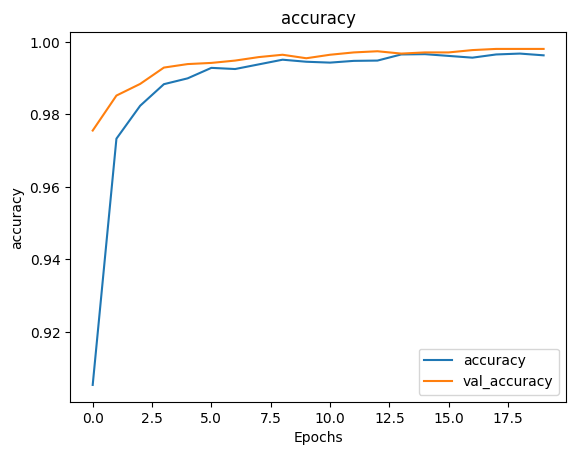

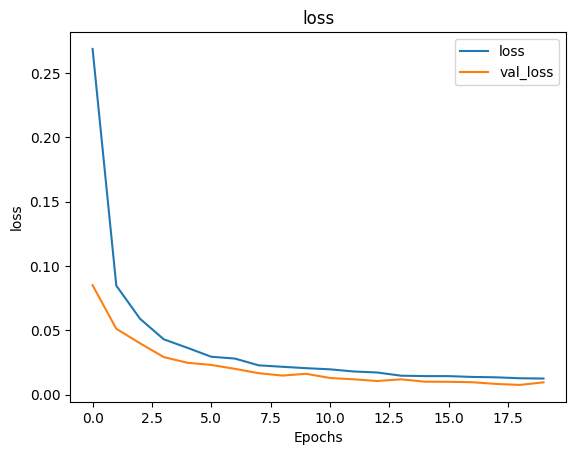

In [20]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [21]:
#optimezes the computation operation at the backend
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
print(model.metrics_names)

['loss', 'accuracy']


In [23]:
test_loss, test_accuracy = model.evaluate(test_ds)

31/31 [==============================] - 2s 49ms/step - loss: 0.0319 - accuracy: 0.9928


In [24]:
print(f"The test loss for our model is {test_loss}")
print(f"The test accuracy for our model is {test_accuracy}")

The test loss for our model is 0.031899940222501755
The test accuracy for our model is 0.9928278923034668


In [25]:
#function that plots our confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [26]:
Y_pred = model.predict(test_ds)

y_pred = np.argmax(Y_pred, axis=1)
y_pred

31/31 [==============================] - 2s 32ms/step


array([0, 2, 1, ..., 3, 2, 0])

In [27]:
y_pred.shape

(1952,)

In [28]:
#getting our model predictions and ground ready for plotting confusion matrix
y_pred = [] 
y_true = []  

for image_batch, label_batch in test_ds:

   y_true.append(label_batch)

   preds = model.predict(image_batch)

   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 40ms/step


In [29]:
len(y_true)

31

Confusion matrix, without normalization


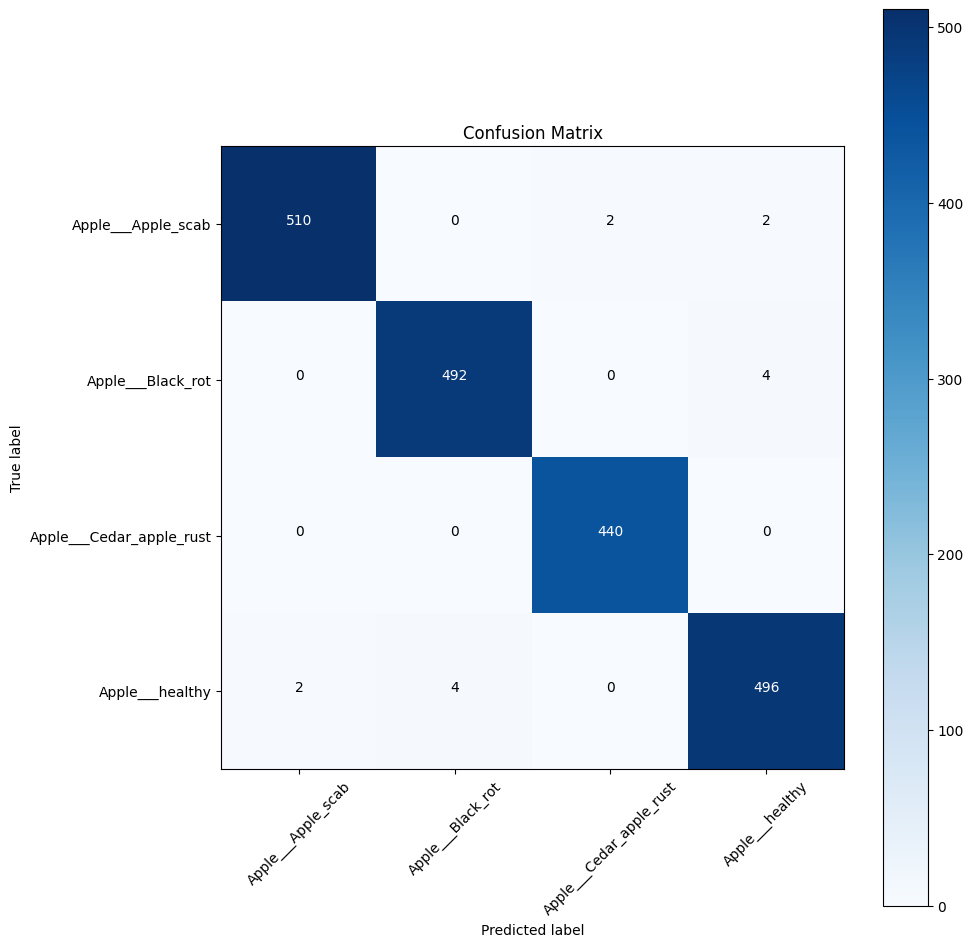

In [30]:
cm1 = confusion_matrix(correct_labels, predicted_labels)

plot_confusion_matrix(cm1, class_names, normalize=False, title='Confusion Matrix')

In [31]:
#averaged f1 score
f1_score(correct_labels, predicted_labels, average='weighted')

0.9928260346416393

In [32]:
#the individual f1_score for all classes
f1_score(correct_labels, predicted_labels, average=None)

array([0.99415205, 0.99193548, 0.99773243, 0.98804781])